In [1]:
%matplotlib inline
import plot
import market
import metrics
from decimal import Decimal
import pandas

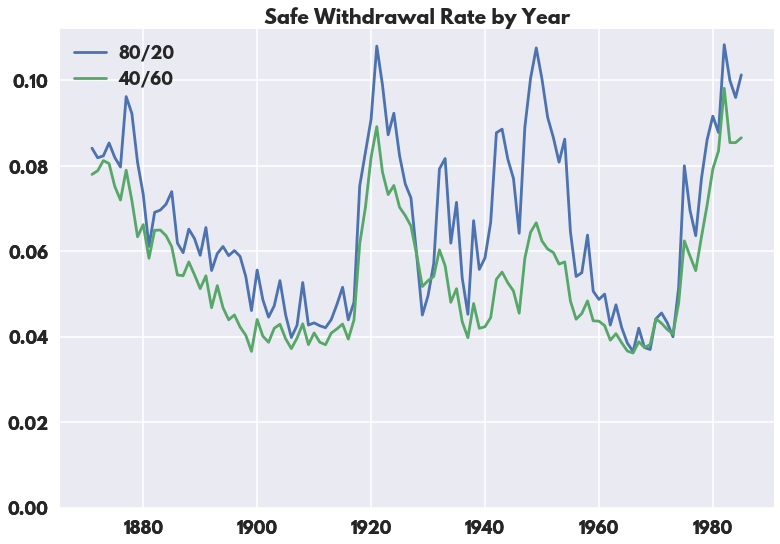

In [2]:
m = market.Returns_US_1871()
years = 30
start_year = 1871
last_year = 2015-years

def run(stock_pct):
    swrs = pandas.Series()
    for _ in range(last_year - start_year + 1):
        returns = []
#        if start_year + _ in (1965,1966,1967,1968,1969): continue
        for one_year in zip(range(years), m.iter_from(start_year + _)):
            annual_returns = one_year[1]
            stocks = annual_returns.stocks - annual_returns.inflation
            bonds = annual_returns.bonds - annual_returns.inflation
            returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        swr = float(metrics.ssr(returns))
#        print(start_year+_, swr)
        swrs.loc[start_year+_] = swr
    return swrs

six = run(Decimal('.6'))
three = run(Decimal('.3'))
four = run(Decimal('.4'))
eight = run(Decimal('.8'))
nine = run(Decimal('.9'))
five = run(Decimal('.5'))

#diff = filter(lambda x: x>0, [(x[0] - x[1])*100 for x in zip(eight, four)])

plot.plot_n({'80/20': eight, '40/60' : four}, '', 'Safe Withdrawal Rate by Year', add_commas=False)
#plot.plot_n({'80/20 - 40/60' : list(diff)}, '', 'SWR Tell Tale Chart', add_commas=False, zero_based=False)

In [5]:
print(nine.min(), eight.min(), six.min(), five.min(), four.min(), sep='\n')

0.0362342860132
0.0365390881668
0.0366683635088
0.0364944901211
0.0361637121385


In [4]:
m = market.Returns_US_1871()
years = 30
start_year = 1871
last_year = 2015-years

def get_stock_pct(year):
    if year < 10:
        return Decimal('.4')
    elif year < 20:
        return Decimal('.5')
    else:
        return Decimal('.6')


def run():
    swrs = pandas.Series()
    for _ in range(last_year - start_year + 1):
        returns = []
        for one_year in zip(range(years), m.iter_from(start_year + _)):
            annual_returns = one_year[1]
            stock_pct = get_stock_pct(one_year[0])
            stocks = annual_returns.stocks - annual_returns.inflation
            bonds = annual_returns.bonds - annual_returns.inflation
            returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        swr = float(metrics.ssr(returns))
        swrs.loc[start_year+_] = swr
    return swrs

run().sort_values()

1966    0.037072
1899    0.037387
1906    0.037914
1965    0.038107
1968    0.038583
1909    0.038705
1964    0.039015
1969    0.039229
1962    0.039374
1912    0.039383
1911    0.039541
1967    0.039620
1916    0.039739
1902    0.039806
1907    0.040300
1963    0.040687
1905    0.040916
1910    0.041111
1901    0.041119
1973    0.041506
1898    0.041871
1913    0.041922
1937    0.042154
1972    0.042282
1897    0.042594
1961    0.042795
1914    0.042804
1903    0.042845
1971    0.043501
1960    0.043750
          ...   
1883    0.065841
1884    0.065929
1882    0.066108
1948    0.066401
1927    0.067192
1949    0.067367
1880    0.067438
1919    0.068931
1926    0.070026
1979    0.071636
1876    0.073083
1878    0.073184
1925    0.073385
1923    0.076760
1875    0.076828
1924    0.077880
1871    0.078048
1872    0.078968
1980    0.079388
1877    0.080079
1920    0.081086
1873    0.081300
1922    0.081329
1874    0.081414
1981    0.084352
1984    0.086709
1983    0.086808
1985    0.0877

In [9]:
m = market.Returns_US_1871()
years = 30
start_year = 1871
last_year = 2015-years

def get_stock_pct(stocks, bonds):
    if stocks < bonds:
        return Decimal('.4')
    else:
        return Decimal('.6')

def run():
    swrs = pandas.Series()
    for _ in range(last_year - start_year + 1):
        returns = []
        for one_year in zip(range(years), m.iter_from(start_year + _)):
            annual_returns = one_year[1]
            stocks = annual_returns.stocks - annual_returns.inflation
            bonds = annual_returns.bonds - annual_returns.inflation
            stock_pct = get_stock_pct(stocks, bonds)
            returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        swr = float(metrics.ssr(returns))
        swrs.loc[start_year+_] = swr
    return swrs

run().sort_values()

1966    0.043682
1968    0.044325
1965    0.044701
1969    0.044805
1906    0.045475
1909    0.046274
1912    0.046571
1911    0.046674
1899    0.047028
1967    0.047383
1964    0.047546
1973    0.047900
1916    0.048470
1910    0.048647
1962    0.048771
1902    0.048913
1907    0.049128
1905    0.049312
1913    0.049877
1972    0.050019
1937    0.051085
1963    0.051367
1901    0.051519
1971    0.051736
1914    0.051894
1970    0.052415
1898    0.053067
1903    0.053109
1939    0.053718
1908    0.054012
          ...   
1952    0.081178
1951    0.082890
1932    0.083103
1979    0.083370
1876    0.084148
1875    0.086431
1948    0.086878
1950    0.087267
1878    0.087388
1871    0.088003
1919    0.088017
1872    0.088102
1927    0.090356
1873    0.090578
1874    0.091105
1980    0.091727
1926    0.091805
1949    0.092376
1981    0.093004
1877    0.093948
1925    0.094880
1923    0.095578
1984    0.097217
1983    0.098314
1985    0.100247
1920    0.101148
1924    0.101615
1922    0.1033